# Оценка качества модели

## Импорт библиотек

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

## Загрузка модели

In [ ]:
# Загрузка модели
model = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/Проектный практикум 3/model')

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Проектный практикум 3/model')

## Генерация отзывов

Сгенерируем отзывы с рейтингами от 1 до 5 для топ-5 рубрик и ключевых слов из датасета (категории и ключевые слова по ним были извлечены из исходного датасета, на котором проводилось обучение модели), а также вычисленим perplexity для каждого отзыва.


При генерации будем использовать следующие параметры:
- max_length=150,
- num_return_sequences=1,
- no_repeat_ngram_size=2,
- do_sample=True,
- top_p=0.95,
- top_k=60,
- temperature=1

In [ ]:
# Генерация отзыва
def gen_review(input_text, model, tokenizer, params):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    output = model.generate(
        input_ids,
        max_length=params['max_length'],
        num_return_sequences=params['num_return_sequences'],
        no_repeat_ngram_size=params['no_repeat_ngram_size'],
        do_sample=params['do_sample'],
        top_p=params['top_p'],
        top_k=params['top_k'],
        temperature=params['temperature'],
        eos_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
# Функция для обработки текста отзыва
def capitalize_and_punctuate(text):
    # Извлекаем часть текста после последнего двоеточия
    text = text.split(":")[-1].strip()

    # Разделяем текст на предложения по общим знакам препинания
    sentences = []
    current_sentence = []
    for char in text:
        current_sentence.append(char)
        # Если встречаем знак конца предложения, добавляем его в список предложений
        if char in '.!?':
            sentences.append(''.join(current_sentence).strip())
            current_sentence = []

    # Если остался текст, добавляем его как последнее предложение
    if current_sentence:
        sentences.append(''.join(current_sentence).strip())

    # Обрабатываем каждое предложение, чтобы сделать первую букву заглавной
    corrected_sentences = []
    for sentence in sentences:
        if sentence:
            # Делаем первую букву заглавной и добавляем точку в конце, если её нет
            corrected_sentence = sentence[0].upper() + sentence[1:]
            if not corrected_sentence.endswith('.'):
                corrected_sentence += '.'
            corrected_sentences.append(corrected_sentence)

    # Объединяем все исправленные предложения в финальный текст
    final_text = ' '.join(corrected_sentences)
    return final_text

In [ ]:
# Функция для вычисления perplexity
def calculate_perplexity(text, model, tokenizer):
    # Токенизация текста
    input_ids = tokenizer.encode(text, return_tensors='pt')

    # Вычисление потерь (loss)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    # Вычисление perplexity
    perplexity = torch.exp(loss)
    return perplexity.item()

In [ ]:
# Параметры генерации
params = {}
params['max_length'] = 150
params['num_return_sequences'] = 1
params['no_repeat_ngram_size'] = 2
params['do_sample'] = True
params['top_p'] = 0.95
params['top_k'] = 60
params['temperature'] = 1

In [ ]:
def generate_text(category, rating, key_words):
    # Ввод новых параметров
    input_text = f"Категория: {category}; Рейтинг: {rating}; Ключевые слова: {key_words} -> Отзыв:"

    # Генерация отзыва
    generated_text = gen_review(input_text, model, tokenizer, params)
    generated_text = capitalize_and_punctuate(generated_text)

    # Вычисление perplexity
    perplexity = calculate_perplexity(generated_text, model, tokenizer)

    return generated_text, perplexity

In [ ]:
# Функция добавления отзыва и perplexityв DataFrame
def analyze_and_add_to_dataset(category, rating, key_words, df):
    text, perplexity = generate_text(category, rating, key_words)
    new_data = {
        'text': text,
        'category': category,
        'rating': rating,
        'key_words': key_words,
        'perplexity': perplexity,
    }
    new_row = pd.DataFrame([new_data])
    new_row = new_row.dropna(axis=1, how='all')
    df = pd.concat([df, new_row], ignore_index=True)
    return df

In [ ]:
# Загружаем ключевые слова для каждой рубрики выделенные из датасета
tf_idf_aspects = pd.read_csv('/content/drive/MyDrive/Проектный практикум 3/tf_idf_aspects.csv')


In [ ]:
tf_idf_aspects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rubrics  1244 non-null   object
 1   words    1244 non-null   object
 2   reviews  1244 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 29.3+ KB


In [ ]:
tf_idf_aspects.head()

,rubrics,words,reviews
0,Кафе,"цена, персонал, обслуживание, место, меню, кух...",58496
1,Ресторан,"цена, ресторан, персонал, обслуживание, музыка...",56761
2,Гостиница,"этаж, место, вид, вода, гостиница, день, еда, ...",43133
3,Магазин продуктов,"цена, товар, продукт, персонал, магазин, касса...",21346
4,Супермаркет,"цена, товар, продукт, персонал, очередь, магаз...",19746


Сгенерируем отзывы с рейтингам от 1 до 5 для топ-5 рубрик и ключевых слов из датасета (категории и ключевые слова по ним были извлечены из исходного датасета, на котором проводилось обучение модели), а также вычисленим perplexity для каждого отзыва.

In [ ]:
# Создаем пустой DataFrame
df_eval = pd.DataFrame(columns=['text', 'category', 'rating', 'key_words', 'perplexity'])

In [ ]:
# Генерируем и анализируем отзывы
for idx in range(5):
    for rating in range(1, 6):
        df_eval = analyze_and_add_to_dataset(tf_idf_aspects['rubrics'][idx],
                                        rating,
                                        tf_idf_aspects['words'][idx],
                                        df_eval)

<ipython-input-89-a267200341a7>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [3]:
df_eval

,text,category,rating,key_words,perplexity
0,Были с мужем проездом в г. В челябинск. Посети...,Кафе,1,"цена, персонал, обслуживание, место, меню, кух...",29.638271
1,Был проездом в москве посетили это заведение. ...,Кафе,2,"цена, персонал, обслуживание, место, меню, кух...",31.554161
2,Если хотите чтобы вас накормили разнообразно и...,Кафе,3,"цена, персонал, обслуживание, место, меню, кух...",22.850021
3,Сегодня был свидетелем этой свадьбы. Это завед...,Кафе,4,"цена, персонал, обслуживание, место, меню, кух...",30.676085
4,В основном это кафе на первом этаже. Мы остана...,Кафе,5,"цена, персонал, обслуживание, место, меню, кух...",33.650982
5,Еда. . На улице жара а в доме - жара. - были в...,Ресторан,1,"цена, ресторан, персонал, обслуживание, музыка...",30.906738
6,Были в ресторане очень понравилось заведение н...,Ресторан,2,"цена, ресторан, персонал, обслуживание, музыка...",41.778538
7,Первый раз я здесь были в кафе с детьми в конц...,Ресторан,3,"цена, ресторан, персонал, обслуживание, музыка...",34.690510
8,Решили отпраздновать день рождения в этом заве...,Ресторан,4,"цена, ресторан, персонал, обслуживание, музыка...",29.401497
9,Были проездом в казани. На завтрак взяли хачап...,Ресторан,5,"цена, ресторан, персонал, обслуживание, музыка...",33.054794


## Оцениваем качество отзывов

Можно визуально оценить соответствие текста отзыва категории, рейтингу и ключевым словам. И посмотреть perplexity.

In [6]:
for idx in range(5):
    display(f"Отзыв: {df_eval['text'][idx]}")
    display(f"Категория: {df_eval['category'][idx]}")
    display(f"Рейтинг: {df_eval['rating'][idx]}")
    display(f"Ключевые слова: {df_eval['key_words'][idx]}")
    display(f"Perplexity: {df_eval['perplexity'][idx]}")
    display("************************************")

'Отзыв: Были с мужем проездом в г. В челябинск. Посетили кафе урал и выбрали это кафе по отзывам. Заказали плов. Плов был из говядины и свинины. Но он был не тот к которому привыкли с момента открытия. Нам дали плов на что администратор сказала что такого нет может просто плов не брали не предупредили. У нас был свой маленький ребенок которому очень не хватало мяса но наш официант сказал что он не ест плов с говядиной. Мы попросили его взять нам было сказано что такой не бывает. На нашу просьбу принести.'

'Категория: Кафе'

'Рейтинг: 1'

'Ключевые слова: цена, персонал, обслуживание, место, меню, кухня, кафе, заведение, еда, блюдо, атмосфера'

'Perplexity: 29.63827133178711'

'************************************'

'Отзыв: Был проездом в москве посетили это заведение. Мы с супругой и тремя детьми. Очень понравился интерьер обстановка и обстановка заведения все очень красиво и качественно сервированные столы. Все блюда очень вкусные как домашние так и привычные для нас супы салаты. Порции довольно большие очень сытно и вкусно. Из минусов при выборе блюда нужно учитывать что у нас был один большой стол и маленький ребенок с маленьким столиком. Было крайне некомфортно в детской комнате на улице тем не менее ребёнок начал кушать и сразу начали кушать. По приходу к нам официант был уже.'

'Категория: Кафе'

'Рейтинг: 2'

'Ключевые слова: цена, персонал, обслуживание, место, меню, кухня, кафе, заведение, еда, блюдо, атмосфера'

'Perplexity: 31.554161071777344'

'************************************'

'Отзыв: Если хотите чтобы вас накормили разнообразно и вкусно - это не сюда. Меню. Первое. Шашлык овощи и помидоры - только в одном месте. Второе. Супы из баранины овощи в супе и пюре из картошки фри. Все - порция большая. Пельмени из куриной печени очень не плохие. Бульон куриный с сыром - тоже. Котлетки котлеты с говядиной - очень вкусные. Люля кебаб - огонь. Но вот люлю с курицей - разочаровало. Картошка фри на.'

'Категория: Кафе'

'Рейтинг: 3'

'Ключевые слова: цена, персонал, обслуживание, место, меню, кухня, кафе, заведение, еда, блюдо, атмосфера'

'Perplexity: 22.850021362304688'

'************************************'

'Отзыв: Сегодня был свидетелем этой свадьбы. Это заведение - огонь. Когда в мае я был на масленицу и был не один раз то всегда захаживал сюда с женой и друзьями. Там прекрасно всё начиная от подачи блюд и заканчивая обслуживанием. Кухня шикарна все блюда которые я пробовал вкусны и красиво оформлены. По сравнению с другими местами в других местах в меню есть что то непонятное и непонятное я там был впервые и это было неприятно и огорчило. Еда конечно хороша но не скажу что она настолько разнообразна в её порции. Но я.'

'Категория: Кафе'

'Рейтинг: 4'

'Ключевые слова: цена, персонал, обслуживание, место, меню, кухня, кафе, заведение, еда, блюдо, атмосфера'

'Perplexity: 30.676084518432617'

'************************************'

'Отзыв: В основном это кафе на первом этаже. Мы останавливались на одну ночь в этом отеле. Место удобное недалеко от набережной. По кухне и обслуживанию всё хорошо. Порции достаточные есть что выбрать на свой вкус. Из минусов то что для детей есть детская комната где им можно покачаться в гамаке. Также у кафе грязно. В детской комнате очень много детей. Дети все в одном - месте. И на столе и в шкафу. К самому кафе претензий нет все чисто и аккуратно есть даже вода чай и печенье в качестве подарков на выбор. Интерьер.'

'Категория: Кафе'

'Рейтинг: 5'

'Ключевые слова: цена, персонал, обслуживание, место, меню, кухня, кафе, заведение, еда, блюдо, атмосфера'

'Perplexity: 33.65098190307617'

'************************************'

В целом, данные отзывы можно оценить как среднего качества. Среди них встречаются как хорошо структурированные и информативные тексты, так и те, которые нуждаются в улучшении.

In [ ]:
# Сохраняем результат
df_eval.to_csv('/content/drive/MyDrive/Проектный практикум 3/df_eval.csv', index=False)

Теперь количественно оценим, сколько ключевых слов из эталонного списка присутствует в тексте отзыва.

Для количественной оценки качества модели, сгруппируем данные по категориям и для каждой категории объединяем тексты отзывов. Вычисляем среднее значение perplexity для оценки языковой связности и грамотности текста. Используя набор ключевых слов для каждой категории, рассчитываем процент присутствия этих ключевых слов в объединённом тексте относительно общего их количества, чтобы измерить тематическую релевантность. Комбинируя показатели perplexity и покрытие ключевых слов, получаем комплексную оценку качества модели, учитывающую как языковую точность, так и соответствие содержанию заданным категориям.

In [ ]:
# Группировка по категориям, объединение текстов и вычисление среднего perplexity
grouped = df_eval.groupby('category').agg(
    combined_text=('text', ' '.join),
    average_perplexity=('perplexity', 'mean'),
    key_words=('key_words', lambda x: ', '.join(set(x)))
).reset_index()

In [ ]:
grouped

,category,combined_text,average_perplexity,key_words
0,Гостиница,Останавливались семьей на сутки. Остановились ...,27.376440,"этаж, место, вид, вода, гостиница, день, еда, ..."
1,Кафе,Были с мужем проездом в г. В челябинск. Посети...,29.673904,"цена, персонал, обслуживание, место, меню, кух..."
2,Магазин продуктов,Были в магазине вчера купили кингстайл молочны...,32.405736,"цена, товар, продукт, персонал, магазин, касса..."
3,Ресторан,Еда. . На улице жара а в доме - жара. - были в...,33.966415,"цена, ресторан, персонал, обслуживание, музыка..."
4,Супермаркет,Я бы хотела поделиться отзывом об этом магазин...,32.817636,"цена, товар, продукт, персонал, очередь, магаз..."


In [ ]:
# Вычислим процент ключевых слов из списка, которые присутствуют в тексте отзыва
def calculate_keyword_percentage(row):
    text = row['combined_text'].lower()
    keywords = row['key_words'].lower().split(', ')
    keyword_count = sum(1 for keyword in keywords if keyword in text)
    total_keywords = len(keywords)
    return (keyword_count / total_keywords * 100) if total_keywords > 0 else 0

grouped['keyword_percentage'] = grouped.apply(calculate_keyword_percentage, axis=1)

In [ ]:
grouped

,category,combined_text,average_perplexity,key_words,keyword_percentage
0,Гостиница,Останавливались семьей на сутки. Остановились ...,27.376440,"этаж, место, вид, вода, гостиница, день, еда, ...",40.000000
1,Кафе,Были с мужем проездом в г. В челябинск. Посети...,29.673904,"цена, персонал, обслуживание, место, меню, кух...",63.636364
2,Магазин продуктов,Были в магазине вчера купили кингстайл молочны...,32.405736,"цена, товар, продукт, персонал, магазин, касса...",87.500000
3,Ресторан,Еда. . На улице жара а в доме - жара. - были в...,33.966415,"цена, ресторан, персонал, обслуживание, музыка...",46.153846
4,Супермаркет,Я бы хотела поделиться отзывом об этом магазин...,32.817636,"цена, товар, продукт, персонал, очередь, магаз...",70.000000


 Визуализируем процент ключевых слов и среднее значение perplexity для каждой категории

<ipython-input-138-ee08f5db0318>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


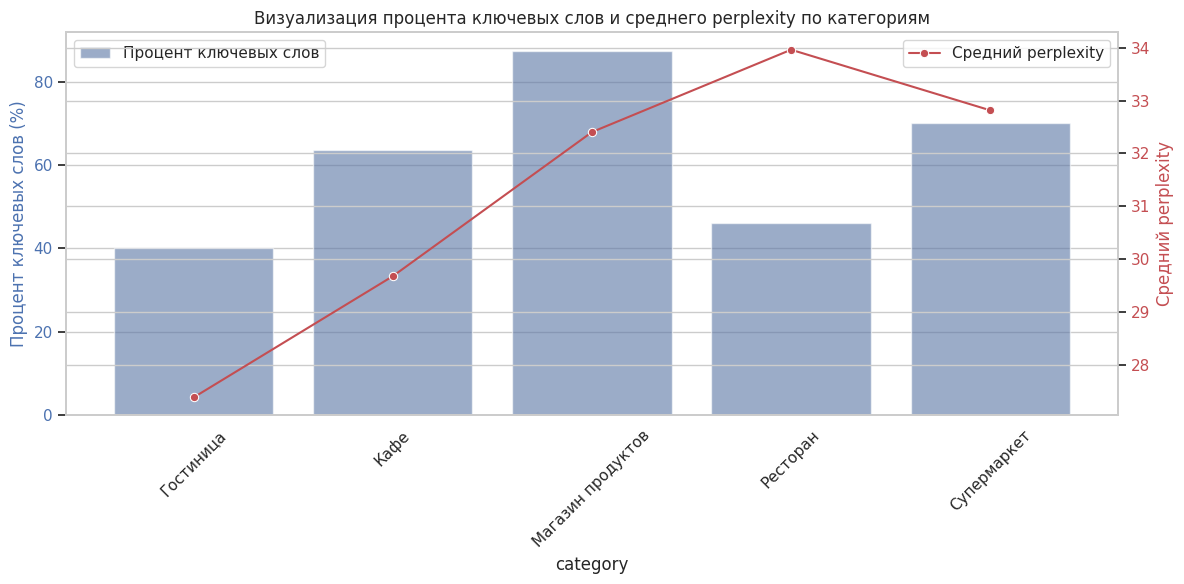

In [ ]:
# Устанавливаем стиль графиков
sns.set(style="whitegrid")

# Создаем фигуру и оси
fig, ax1 = plt.subplots(figsize=(12, 6))

# Столбчатая диаграмма для процента ключевых слов
sns.barplot(x='category', y='keyword_percentage', data=grouped, ax=ax1, color='b', alpha=0.6, label='Процент ключевых слов')
ax1.set_ylabel('Процент ключевых слов (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Создаем вторую ось для среднего perplexity
ax2 = ax1.twinx()
sns.lineplot(x='category', y='average_perplexity', data=grouped, ax=ax2, color='r', marker='o', label='Средний perplexity')
ax2.set_ylabel('Средний perplexity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Добавляем заголовок и легенду
plt.title('Визуализация процента ключевых слов и среднего perplexity по категориям')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Показываем график
plt.tight_layout()
plt.show()

In [ ]:
# Сохраняем результат
df_eval.to_csv('/content/drive/MyDrive/Проектный практикум 3/metrics.csv', index=False)

Можно сделать следующие выводы о качестве генерирования отзывов:

Высокий процент ключевых слов указывает на значительную релевантность контента. Например, категория "Магазин продуктов" демонстрирует 87.5% ключевых слов, что свидетельствует о фокусе на основных аспектах темы.

Значения перплексии, варьирующиеся от 27.37 до 33.97, указывают на различную сложность текста. Низкая перплексия в категории "Гостиница" может отражать более простую и прямую структуру отзывов, что улучшает читаемость.

 Разнообразие ключевых слов по различным категориям (например, "цена", "персонал") предполагает способность модели охватить основные аспекты каждой темы, способствуя созданию содержательного отзыва.

Эти указывает на способность нейронной сети генерировать содержательные и тематически релевантные отзывы, отражающие основные аспекты каждой категории.